## Daisy's Test/Train Code


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# Set path to local data directory
folder_path = ""

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


In [4]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation', 'bid_ask_spread'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN,0.26
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000,0.26
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016,0.24
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016,0.24
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033,0.30


In [5]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()

,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


In [6]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()

,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


In [7]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,0.01,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,0.02,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,0.01,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,0.01,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,0.01,2021-10-07 16:00:00


In [8]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)

TimeID Split:
Train shape: (28513833, 10)
Test shape: (7043618, 10)


In [9]:
qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()
qqq_df["date_only"] = qqq_df["datetime"].dt.date

qqq_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime,date_only
31393488,104919,6,2992.0,312.299875,0.000032,0.975000,79.000000,0.000017,0.01,NaT,NaT
31393489,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,0.02,NaT,NaT
31393490,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,0.02,NaT,NaT
31393491,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,0.02,NaT,NaT
31393492,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,0.02,NaT,NaT


In [10]:
#  Compute log returns (per time_id)
qqq_df["log_return"] = qqq_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))

# Compute realized volatility per time_id
rv_df = qqq_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into qqq_df
qqq_df = pd.merge(qqq_df, rv_df, on="time_id", how="left")

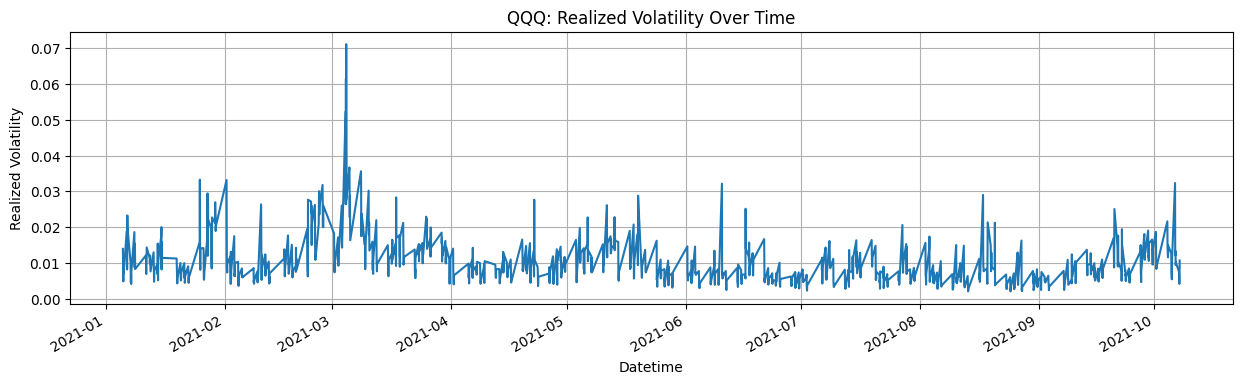

In [11]:
# Plot volatility over time
qqq_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="QQQ: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()

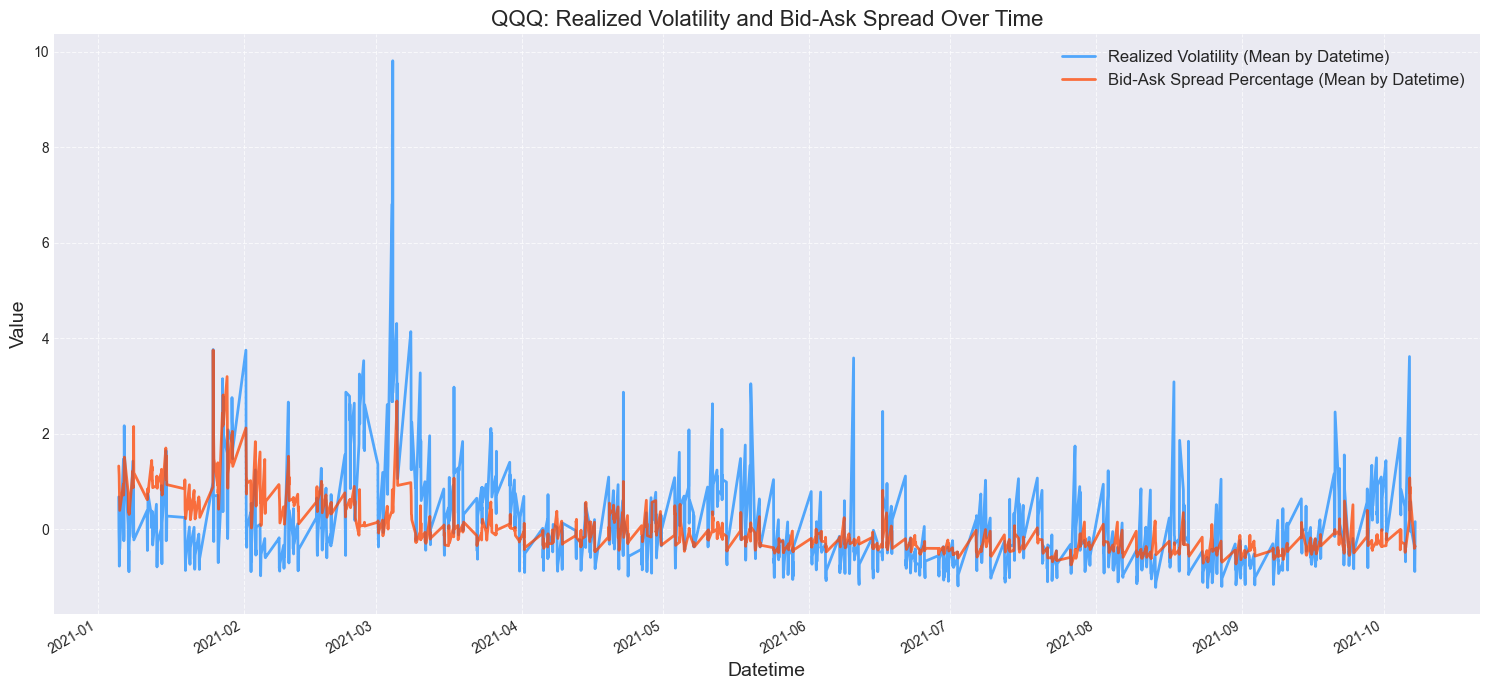

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
qqq_df[['spread_pct_scaled', 'realized_volatility_scaled']] = scaler.fit_transform(qqq_df[['spread_pct', 'realized_volatility']])


realized_vol_by_datetime = qqq_df.groupby("datetime")["realized_volatility_scaled"].mean()
bid_ask_spread_by_datetime = qqq_df.groupby("datetime")["spread_pct_scaled"].mean()

# Plotting
plt.figure(figsize=(15, 7)) # Adjusted figsize for better visibility of two lines
plt.style.use('seaborn-v0_8-darkgrid')

realized_vol_by_datetime.plot(
    label="Realized Volatility (Mean by Datetime)",
    color='dodgerblue',
    linewidth=2,
    alpha=0.75
)
bid_ask_spread_by_datetime.plot(
    label="Bid-Ask Spread Percentage (Mean by Datetime)",
    color='orangered',
    linewidth=2,
    alpha=0.75
)

plt.title("QQQ: Realized Volatility and Bid-Ask Spread Over Time", fontsize=16)
plt.xlabel("Datetime", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# XGBOOST

## Using 80/20 split on time_id for test/training data

In [13]:
xgb_df = qqq_df.copy()

In [14]:
features_to_lag = ["realized_volatility", "wap", "imbalance", "spread_variation", "spread_pct", "depth_ratio", "log_return"]

for feature in features_to_lag:
    for lag in [1, 5, 10]:
        xgb_df[f"{feature}_lag_{lag}"] = xgb_df[feature].shift(lag)

xgb_df = xgb_df.dropna().reset_index(drop=True)

In [15]:
current_features = ["wap", "spread_pct", "imbalance", "depth_ratio", "spread_variation", "log_return"]
lagged_features = [col for col in xgb_df.columns if 'lag' in col]

feature_columns = current_features + lagged_features

In [16]:
X = xgb_df[feature_columns]
y = xgb_df["realized_volatility"]

cutoff = int(len(xgb_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [17]:
from xgboost import XGBRegressor

In [18]:
xgb_model = XGBRegressor(
    n_estimators=100, #number of decision tress
    max_depth=4, #limits how complex each tree can be - avoids overfitting
    learning_rate=0.1, #how much each tree "corrects" the model
    objective='reg:squarederror', #goal is to predict continuous number
    random_state=42 # fixes randomness for repeatability
)

In [19]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
X_test

,wap,spread_pct,imbalance,depth_ratio,spread_variation,log_return,realized_volatility_lag_1,realized_volatility_lag_5,realized_volatility_lag_10,wap_lag_1,...,spread_variation_lag_10,spread_pct_lag_1,spread_pct_lag_5,spread_pct_lag_10,depth_ratio_lag_1,depth_ratio_lag_5,depth_ratio_lag_10,log_return_lag_1,log_return_lag_5,log_return_lag_10
3308505,368.451000,0.000027,-0.800000,0.111111,0.000013,0.000051,0.002056,0.002056,0.002056,368.432143,...,0.000013,0.000027,0.000054,0.000054,0.272727,0.801175,0.377778,-0.000076,6.643770e-06,-0.000016
3308506,368.462308,0.000027,-0.538462,0.300000,0.000013,0.000031,0.002056,0.002056,0.002056,368.451000,...,0.000011,0.000027,0.000054,0.000027,0.111111,0.111111,3.578275,0.000051,8.424100e-06,0.000006
3308507,368.471155,0.000027,-0.769088,0.130526,0.000009,0.000024,0.002056,0.002056,0.002056,368.462308,...,0.000009,0.000027,0.000054,0.000027,0.300000,0.909091,86.153846,0.000031,2.041984e-05,0.000006
3308508,368.475370,0.000027,0.074074,1.160000,0.000009,0.000011,0.002056,0.002056,0.002056,368.471155,...,0.000009,0.000027,0.000027,0.000027,0.130526,1100.000000,3.578275,0.000024,1.267731e-06,-0.000006
3308509,368.471840,0.000027,-0.632047,0.225455,0.000009,-0.000010,0.002056,0.002056,0.002056,368.475370,...,0.000011,0.000027,0.000027,0.000054,1.160000,0.272727,0.475825,0.000011,-7.558246e-05,-0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135627,364.045714,0.000055,-0.428571,0.400000,0.000014,-0.000059,0.010677,0.010677,0.010677,364.067375,...,0.000013,0.000055,0.000027,0.000055,0.584167,0.153846,2.800000,-0.000059,-3.067117e-05,-0.000028
4135628,364.046133,0.000055,-0.386658,0.442317,0.000014,0.000001,0.010677,0.010677,0.010677,364.045714,...,0.000013,0.000055,0.000027,0.000027,0.400000,0.154615,0.771456,-0.000059,1.585933e-08,-0.000029
4135629,364.010909,0.000027,-0.818182,0.100000,0.000014,-0.000097,0.010677,0.010677,0.010677,364.046133,...,0.000013,0.000055,0.000055,0.000055,0.442317,0.876250,0.666667,0.000001,-5.489784e-06,-0.000045
4135630,362.721667,0.000028,-0.666667,0.200000,0.000012,-0.003548,0.010677,0.010677,0.010677,364.010909,...,0.000014,0.000027,0.000027,0.000055,0.100000,8.507042,1.363636,-0.000097,5.385562e-05,-0.000018


In [21]:
y_pred = xgb_model.predict(X_test)

In [22]:
X_test.shape, y_pred.shape

((827127, 27), (827127,))

In [23]:
y_test.head()

3308505    0.002056
3308506    0.002056
3308507    0.002056
3308508    0.002056
3308509    0.002056
Name: realized_volatility, dtype: float64

### Performance Metrics

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
def qlike(y_true, y_pred):
    return np.mean(np.log(y_pred) + (y_true / y_pred))

In [26]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000000005195
QLIKE: -3.926504


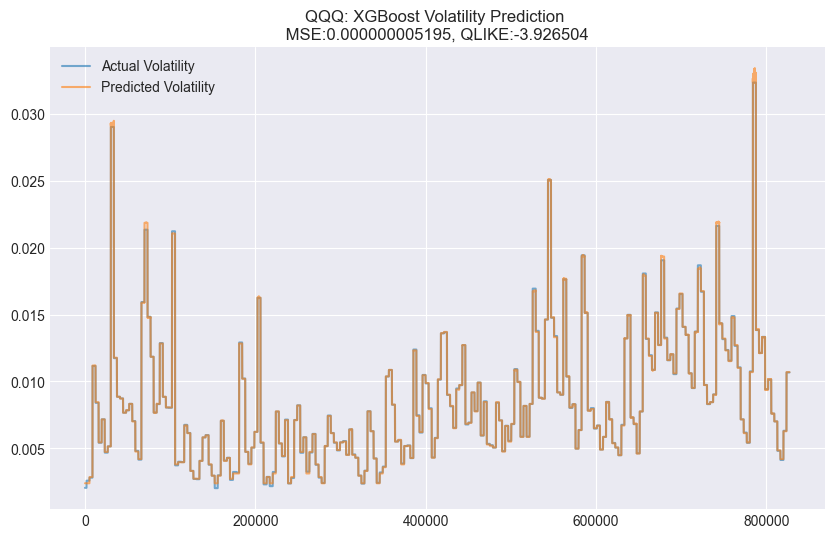

In [27]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"QQQ: XGBoost Volatility Prediction \n MSE:{mse:.12f}, QLIKE:{qlikel:.6f} ")
plt.show()

## Final Version - aggregating data for each time id. 

In [28]:
agg_df = xgb_df.groupby("time_id")["realized_volatility"].mean().reset_index()

In [29]:
X = agg_df.drop(columns=["time_id", "realized_volatility"])  # all features except time_id and target
y = agg_df["realized_volatility"]

In [30]:
agg_df = xgb_df.groupby("time_id").agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()

# Now select features and target
X = agg_df.drop(columns=["time_id", "realized_volatility"])
y = agg_df["realized_volatility"]

In [31]:
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [32]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred = xgb_model.predict(X_test)

# BAS Prediction

## STOCK QQQ

C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\1146839183.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['predicted_volatility_lead1'] = X_pred
C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\1146839183.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)
C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\1146839183.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

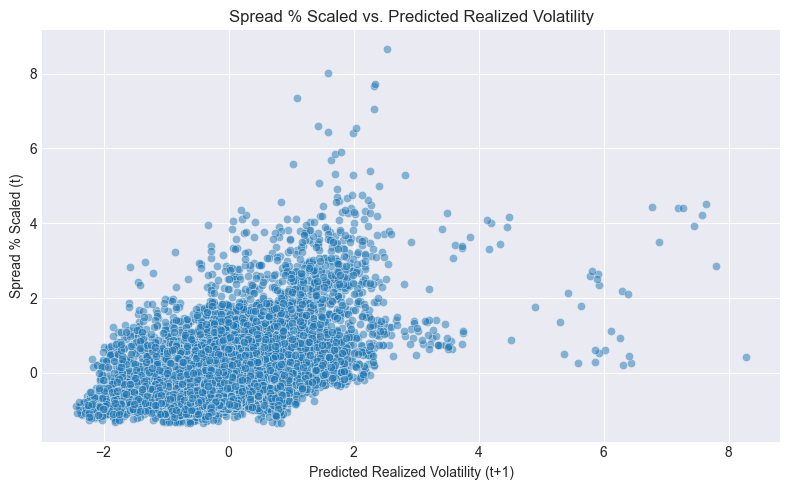


# --- 3. Statistical Assessment ---
# Rainbow test statistic: 4.2398
# P-value: 0.0000
# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).
# Pearson Correlation between Bid-Ask Spread Percentage and Predicted Realized Volatility:
# Correlation coefficient: 0.4925
# P-value: 0
# The correlation is statistically significant.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import pearsonr # Ensure this is imported at the top

xgb_df['bucket_id_330s'] = xgb_df['seconds_in_bucket'] // 330
agg_df = xgb_df.groupby(['time_id', 'bucket_id_330s']).agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()
X = agg_df.drop(columns=["time_id", "bucket_id_330s", "realized_volatility"])
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
X_test = X.iloc[cutoff:]

X_pred = xgb_model.predict(X_train)
X_train['predicted_volatility_lead1'] = X_pred
X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)

scaler = StandardScaler()
X_train["realized_volatility"] = y_train
X_train[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])

X_train_analysis = X_train.dropna(subset=['predicted_volatility_lead1', 'spread_pct_scaled']).copy()

if X_train_analysis.empty:
    print("# DataFrame is empty after dropping NaN values. Cannot proceed with analysis.")
else:

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='predicted_volatility_lead1', y='spread_pct_scaled', data=X_train_analysis, alpha=0.5) # Added alpha for better viz if points overlap
    plt.title('Spread % Scaled vs. Predicted Realized Volatility')
    plt.xlabel('Predicted Realized Volatility (t+1)')
    plt.ylabel('Spread % Scaled (t)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n# --- 3. Statistical Assessment ---")

    X_stat = X_train_analysis[['predicted_volatility_lead1']]
    y_stat = X_train_analysis['spread_pct_scaled']

    X_with_const_stat = sm.add_constant(X_stat)

    try:
        ols_model_stat = sm.OLS(y_stat, X_with_const_stat).fit()
        # Perform Rainbow test
        rainbow_statistic, p_value = linear_rainbow(ols_model_stat)
        print(f"# Rainbow test statistic: {rainbow_statistic:.4f}")
        print(f"# P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).")
        else:
            print("# Interpretation: The Rainbow test shows no evidence against linearity (p-value >= 0.05).")
    except Exception as e:
        print(f"# OLS model fitting or Rainbow test could not be performed: {e}")
        print("# This can happen with insufficient data, perfect multicollinearity, or other data issues.")

    try:
        corr_coef_scipy, p_val_scipy = pearsonr(X_train_analysis['predicted_volatility_lead1'], X_train_analysis['spread_pct_scaled'])
        print(f"# Pearson Correlation between Bid-Ask Spread Percentage and Predicted Realized Volatility:")
        print(f"# Correlation coefficient: {corr_coef_scipy:.4f}")
        print(f"# P-value: {p_val_scipy:.4g}") # Using .4g for scientific notation if p-value is very small
        if p_val_scipy < 0.05:
            print("# The correlation is statistically significant.")
        else:
            print("# The correlation is not statistically significant.")
    except Exception as e:
        print(f"# Pearson correlation could not be computed: {e}")


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# --- Step 1: Create lead target
agg_df['bid_ask_spread_lead1'] = agg_df.groupby('time_id')['bid_ask_spread'].shift(-1)
agg_df = agg_df.dropna(subset=['bid_ask_spread_lead1']).reset_index(drop=True)

# --- Step 2: Prepare features and target
X = agg_df.drop(columns=["time_id", "realized_volatility", "bucket_id_330s", "bid_ask_spread_lead1"])
y = agg_df["bid_ask_spread_lead1"]

cutoff = int(len(agg_df) * 0.8)
X_train = X.iloc[:cutoff].copy()
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:].copy()
y_test = y.iloc[cutoff:]

# --- Step 3: Predict volatility using existing model (must be defined earlier)
X_train['predicted_volatility_lead1'] = xgb_model.predict(X_train)
X_test['predicted_volatility_lead1'] = xgb_model.predict(X_test)

# --- Step 4: Reattach bid_ask_spread_lead1 targets
X_train['bid_ask_spread_lead1'] = y_train.values
X_test['bid_ask_spread_lead1'] = y_test.values

# --- Step 5: Apply scaling (only on train, apply to test)
X_train['realized_volatility'] = agg_df.loc[X_train.index, 'realized_volatility'].values
X_test['realized_volatility'] = agg_df.loc[X_test.index, 'realized_volatility'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
X_train[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = X_train_scaled

X_test_scaled = scaler.transform(X_test[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
X_test[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = X_test_scaled

# --- Step 6: Final feature selection
feature_cols = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled',
                'wap', 'imbalance', 'depth_ratio', 'spread_variation', 'log_return', 'bid_ask_spread']

X_train_final = X_train[feature_cols]
X_test_final = X_test[feature_cols]
y_train_final = X_train['bid_ask_spread_lead1']
y_test_final = X_test['bid_ask_spread_lead1']

# --- Step 7: Model Training and Evaluation
if X_train_final.empty or X_test_final.empty:
    print("Training or test set is empty after split.")
else:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')
    cv_folds = min(5, len(X_train_final)) if len(X_train_final) > 1 else 2

    if len(X_train_final) < 2:
        best_model = xgb_reg.fit(X_train_final, y_train_final)
    else:
        grid_search = GridSearchCV(xgb_reg, param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_final, y_train_final)
        best_model = grid_search.best_estimator_
        print("Best parameters found:", grid_search.best_params_)

    y_pred_best = best_model.predict(X_test_final)

    print(f"MSE: {mean_squared_error(y_test_final, y_pred_best):.6f}")
    print(f"MAE: {mean_absolute_error(y_test_final, y_pred_best):.6f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_best)):.6f}")
    print(f"R²: {r2_score(y_test_final, y_pred_best):.4f}")

    joblib.dump(best_model, "bid_ask_spread_model.pkl")

    # Create comparison df
    comparison_df_best = pd.DataFrame({
        "time_id": agg_df.loc[y_test_final.index, "time_id"].values,
        "bucket_id_330s": agg_df.loc[y_test_final.index, "bucket_id_330s"].values,
        "actual_bid_ask_spread": y_test_final.values,
        "predicted_bid_ask_spread": y_pred_best
    })

    print(comparison_df_best.head())


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
MSE: 0.000001
MAE: 0.000598
RMSE: 0.000854
R²: 0.7887
   time_id  bucket_id_330s  actual_bid_ask_spread  predicted_bid_ask_spread
0      963             6.0               0.012185                  0.013217
1      963             7.0               0.013015                  0.012270
2      963             8.0               0.014154                  0.012857
3      963             9.0               0.012945                  0.013746
4      964             0.0               0.012366                  0.012767


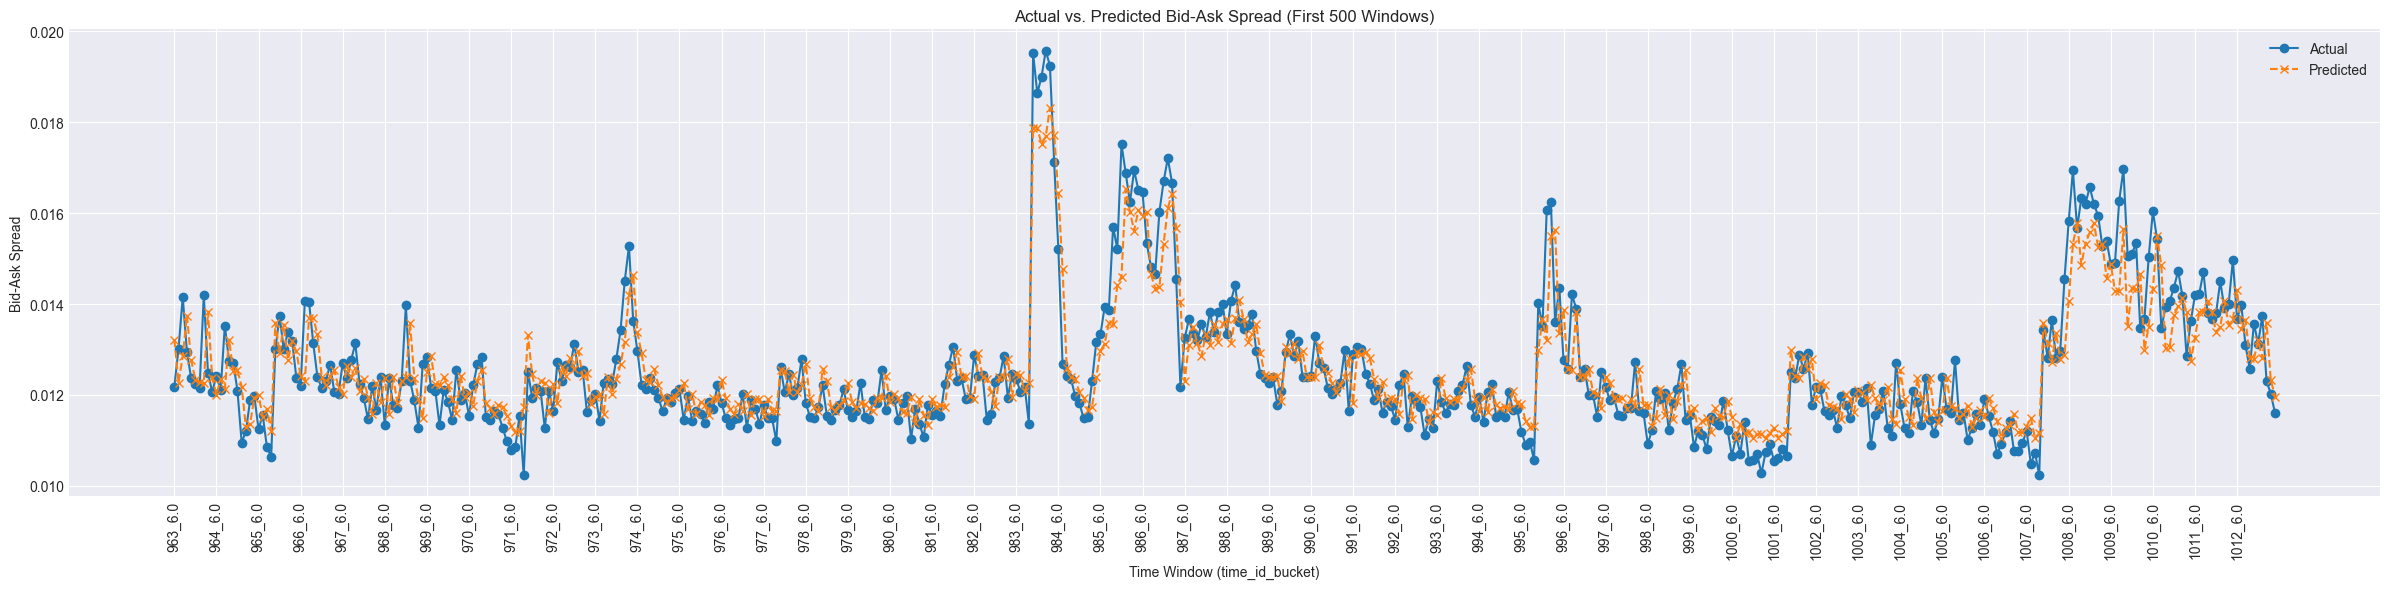

In [36]:
import matplotlib.pyplot as plt

# Slice first 500 rows
subset = comparison_df_best.head(500).copy()

if 'window_label' not in subset.columns:
    subset['window_label'] = subset['time_id'].astype(str) + '_' + subset['bucket_id_330s'].astype(str)

# Plot
plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_bid_ask_spread'], label='Actual', marker='o')
plt.plot(subset['window_label'], subset['predicted_bid_ask_spread'], label='Predicted', marker='x', linestyle='--')

plt.title("Actual vs. Predicted Bid-Ask Spread (First 500 Windows)")
plt.xlabel("Time Window (time_id_bucket)")
plt.ylabel("Bid-Ask Spread")
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation

## Using a persistence model

In [37]:
# XGBoost predictions
y_pred_best = best_model.predict(X_test_final)

# Actual values
y_true = y_test_final

baseline_pred = X_test['bid_ask_spread'].values

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# XGBoost performance
mse_xgb = mean_squared_error(y_true, y_pred_best)
mae_xgb = mean_absolute_error(y_true, y_pred_best)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_true, y_pred_best)

# Baseline performance
mse_baseline = mean_squared_error(y_true, baseline_pred)
mae_baseline = mean_absolute_error(y_true, baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_true, baseline_pred)

# Print comparison
print("\nModel Performance Comparison:")
print("------------------------------------------------------")
print(f"{'Metric':<10} | {'XGBoost':>10} | {'Baseline':>10}")
print("------------------------------------------------------")
print(f"{'MSE':<10} | {mse_xgb:10.6f} | {mse_baseline:10.6f}")
print(f"{'MAE':<10} | {mae_xgb:10.6f} | {mae_baseline:10.6f}")
print(f"{'RMSE':<10} | {rmse_xgb:10.6f} | {rmse_baseline:10.6f}")
print(f"{'R²':<10} | {r2_xgb:10.4f} | {r2_baseline:10.4f}")



Model Performance Comparison:
------------------------------------------------------
Metric     |    XGBoost |   Baseline
------------------------------------------------------
MSE        |   0.000001 |   0.000001
MAE        |   0.000598 |   0.000596
RMSE       |   0.000854 |   0.000863
R²         |     0.7887 |     0.7842


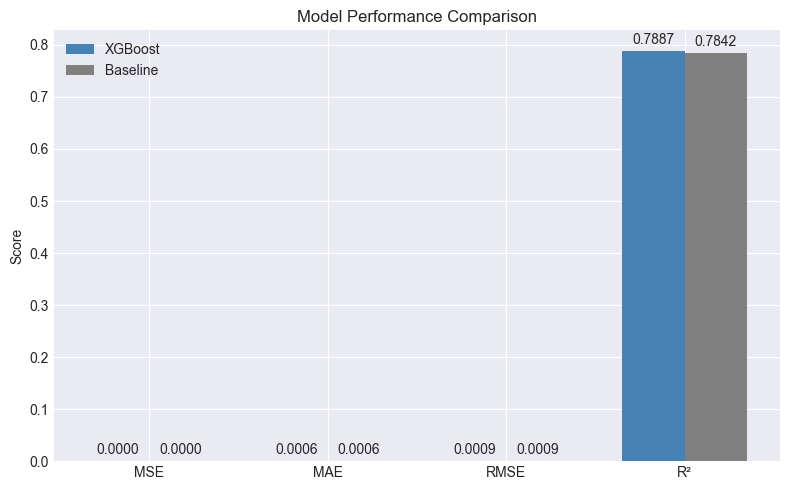

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define metric names and corresponding values
metrics = ['MSE', 'MAE', 'RMSE', 'R²']
xgb_scores = [mse_xgb, mae_xgb, rmse_xgb, r2_xgb]
baseline_scores = [mse_baseline, mae_baseline, rmse_baseline, r2_baseline]

# Set up bar positions and width
x = np.arange(len(metrics))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, xgb_scores, width, label='XGBoost', color='steelblue')
rects2 = ax.bar(x + width/2, baseline_scores, width, label='Baseline', color='gray')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars with their heights
def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above bar
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()


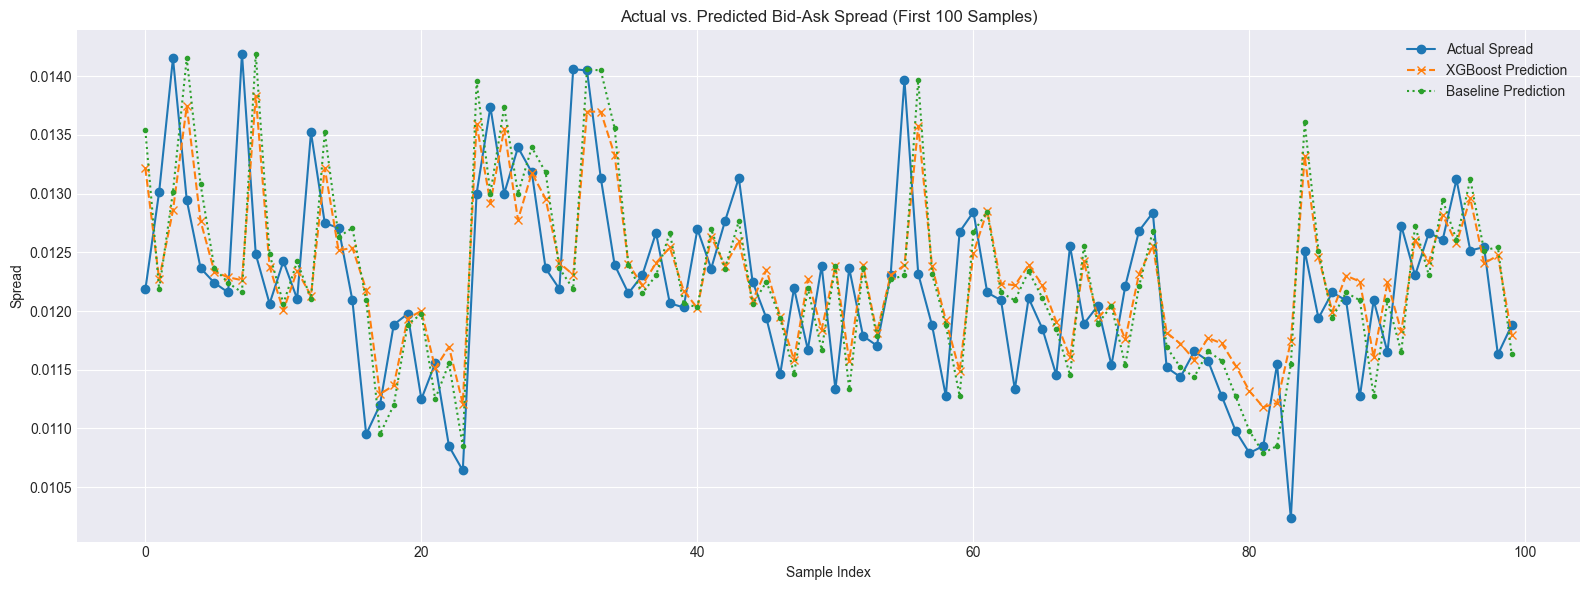

In [40]:
import matplotlib.pyplot as plt

# Slice the first 500 samples
n = 100
y_true_500 = y_true.values[:n]
y_pred_best_500 = y_pred_best[:n]
baseline_pred_500 = baseline_pred[:n]

plt.figure(figsize=(16, 6))
plt.plot(y_true_500, label='Actual Spread', marker='o')
plt.plot(y_pred_best_500, label='XGBoost Prediction', marker='x', linestyle='--')
plt.plot(baseline_pred_500, label='Baseline Prediction', marker='.', linestyle=':')
plt.title('Actual vs. Predicted Bid-Ask Spread (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

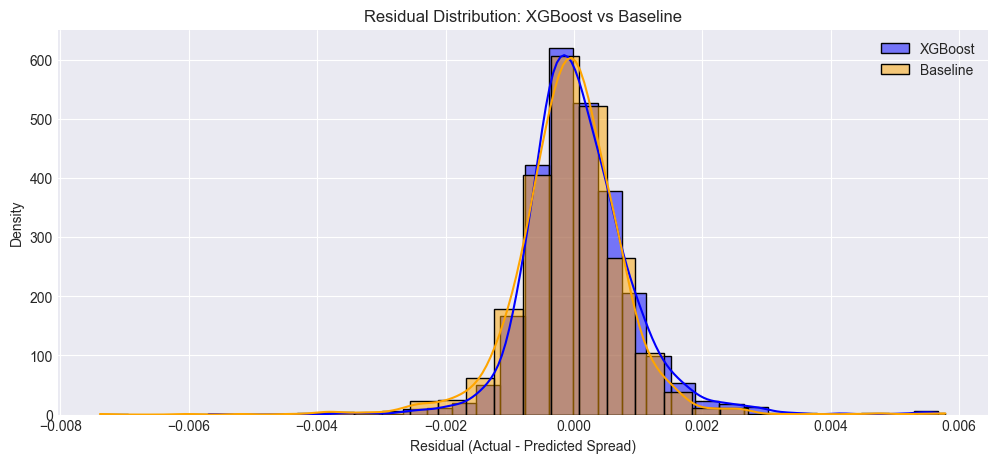

In [41]:
import seaborn as sns

residuals_xgb = y_true - y_pred_best
residuals_baseline = y_true - baseline_pred

plt.figure(figsize=(12, 5))
sns.histplot(residuals_xgb, bins=30, kde=True, color="blue", label="XGBoost", stat="density")
sns.histplot(residuals_baseline, bins=30, kde=True, color="orange", label="Baseline", stat="density")
plt.title("Residual Distribution: XGBoost vs Baseline")
plt.xlabel("Residual (Actual - Predicted Spread)")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
import time

# --- Measure prediction time ---
start_time = time.time()

y_pred_best = best_model.predict(X_test_final)

end_time = time.time()
prediction_time = end_time - start_time

print(f"\nPrediction Time: {prediction_time:.6f} seconds")
print(f"Average Time per Sample: {prediction_time / len(X_test_final):.6f} seconds")



Prediction Time: 0.015826 seconds
Average Time per Sample: 0.000007 seconds


## SPY Stock 50200

In [43]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 50200].copy()
#  Compute log returns (per time_id)
qqq_df["log_return"] = qqq_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))

# Compute realized volatility per time_id
rv_df = qqq_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()
rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into qqq_df
qqq_df = pd.merge(qqq_df, rv_df, on="time_id", how="left")
scaler = StandardScaler()
qqq_df[['spread_pct_scaled', 'realized_volatility_scaled']] = scaler.fit_transform(qqq_df[['spread_pct', 'realized_volatility']])

xgb_df = qqq_df.copy()
features_to_lag = ["realized_volatility", "wap", "imbalance", "spread_variation", "spread_pct", "depth_ratio", "log_return"]

for feature in features_to_lag:
    for lag in [1, 5, 10]:
        xgb_df[f"{feature}_lag_{lag}"] = xgb_df[feature].shift(lag)

xgb_df = xgb_df.dropna().reset_index(drop=True)
agg_df = xgb_df.groupby("time_id")["realized_volatility"].mean().reset_index()

X = agg_df.drop(columns=["time_id", "realized_volatility"])  # all features except time_id and target
y = agg_df["realized_volatility"]
agg_df = xgb_df.groupby("time_id").agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()

# Now select features and target
X = agg_df.drop(columns=["time_id", "realized_volatility"])
y = agg_df["realized_volatility"]
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\1146839183.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['predicted_volatility_lead1'] = X_pred
C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\1146839183.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)
C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\1146839183.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

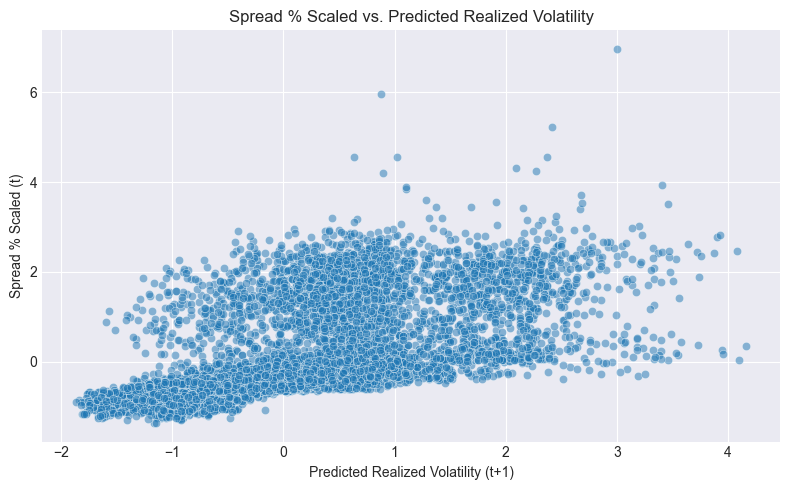


# --- 3. Statistical Assessment ---
# Rainbow test statistic: 6.4571
# P-value: 0.0000
# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).
# Pearson Correlation between Bid-Ask Spread Percentage and Predicted Realized Volatility:
# Correlation coefficient: 0.6510
# P-value: 0
# The correlation is statistically significant.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import pearsonr # Ensure this is imported at the top

xgb_df['bucket_id_330s'] = xgb_df['seconds_in_bucket'] // 330
agg_df = xgb_df.groupby(['time_id', 'bucket_id_330s']).agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()
X = agg_df.drop(columns=["time_id", "bucket_id_330s", "realized_volatility"])
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
X_test = X.iloc[cutoff:]

X_pred = xgb_model.predict(X_train)
X_train['predicted_volatility_lead1'] = X_pred
X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)

scaler = StandardScaler()
X_train["realized_volatility"] = y_train
X_train[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])

X_train_analysis = X_train.dropna(subset=['predicted_volatility_lead1', 'spread_pct_scaled']).copy()

if X_train_analysis.empty:
    print("# DataFrame is empty after dropping NaN values. Cannot proceed with analysis.")
else:

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='predicted_volatility_lead1', y='spread_pct_scaled', data=X_train_analysis, alpha=0.5) # Added alpha for better viz if points overlap
    plt.title('Spread % Scaled vs. Predicted Realized Volatility')
    plt.xlabel('Predicted Realized Volatility (t+1)')
    plt.ylabel('Spread % Scaled (t)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n# --- 3. Statistical Assessment ---")

    X_stat = X_train_analysis[['predicted_volatility_lead1']]
    y_stat = X_train_analysis['spread_pct_scaled']

    X_with_const_stat = sm.add_constant(X_stat)

    try:
        ols_model_stat = sm.OLS(y_stat, X_with_const_stat).fit()
        # Perform Rainbow test
        rainbow_statistic, p_value = linear_rainbow(ols_model_stat)
        print(f"# Rainbow test statistic: {rainbow_statistic:.4f}")
        print(f"# P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).")
        else:
            print("# Interpretation: The Rainbow test shows no evidence against linearity (p-value >= 0.05).")
    except Exception as e:
        print(f"# OLS model fitting or Rainbow test could not be performed: {e}")
        print("# This can happen with insufficient data, perfect multicollinearity, or other data issues.")

    try:
        corr_coef_scipy, p_val_scipy = pearsonr(X_train_analysis['predicted_volatility_lead1'], X_train_analysis['spread_pct_scaled'])
        print(f"# Pearson Correlation between Bid-Ask Spread Percentage and Predicted Realized Volatility:")
        print(f"# Correlation coefficient: {corr_coef_scipy:.4f}")
        print(f"# P-value: {p_val_scipy:.4g}") # Using .4g for scientific notation if p-value is very small
        if p_val_scipy < 0.05:
            print("# The correlation is statistically significant.")
        else:
            print("# The correlation is not statistically significant.")
    except Exception as e:
        print(f"# Pearson correlation could not be computed: {e}")


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# --- Step 1: Create lead target
agg_df['bid_ask_spread_lead1'] = agg_df.groupby('time_id')['bid_ask_spread'].shift(-1)
agg_df = agg_df.dropna(subset=['bid_ask_spread_lead1']).reset_index(drop=True)

# --- Step 2: Prepare features and target
X = agg_df.drop(columns=["time_id", "realized_volatility", "bucket_id_330s", "bid_ask_spread_lead1"])
y = agg_df["bid_ask_spread_lead1"]

cutoff = int(len(agg_df) * 0.8)
X_train = X.iloc[:cutoff].copy()
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:].copy()
y_test = y.iloc[cutoff:]

# --- Step 3: Predict volatility using existing model (must be defined earlier)
X_train['predicted_volatility_lead1'] = xgb_model.predict(X_train)
X_test['predicted_volatility_lead1'] = xgb_model.predict(X_test)

# --- Step 4: Reattach bid_ask_spread_lead1 targets
X_train['bid_ask_spread_lead1'] = y_train.values
X_test['bid_ask_spread_lead1'] = y_test.values

# --- Step 5: Apply scaling (only on train, apply to test)
X_train['realized_volatility'] = agg_df.loc[X_train.index, 'realized_volatility'].values
X_test['realized_volatility'] = agg_df.loc[X_test.index, 'realized_volatility'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
X_train[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = X_train_scaled

X_test_scaled = scaler.transform(X_test[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
X_test[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = X_test_scaled

# --- Step 6: Final feature selection
feature_cols = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled',
                'wap', 'imbalance', 'depth_ratio', 'spread_variation', 'log_return', 'bid_ask_spread']

X_train_final = X_train[feature_cols]
X_test_final = X_test[feature_cols]
y_train_final = X_train['bid_ask_spread_lead1']
y_test_final = X_test['bid_ask_spread_lead1']

# --- Step 7: Model Training and Evaluation
if X_train_final.empty or X_test_final.empty:
    print("Training or test set is empty after split.")
else:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')
    cv_folds = min(5, len(X_train_final)) if len(X_train_final) > 1 else 2

    if len(X_train_final) < 2:
        best_model = xgb_reg.fit(X_train_final, y_train_final)
    else:
        grid_search = GridSearchCV(xgb_reg, param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_final, y_train_final)
        best_model = grid_search.best_estimator_
        print("Best parameters found:", grid_search.best_params_)

    y_pred_best = best_model.predict(X_test_final)
    joblib.dump(best_model, "bid_ask_spread_model.pkl")

    print(f"MSE: {mean_squared_error(y_test_final, y_pred_best):.6f}")
    print(f"MAE: {mean_absolute_error(y_test_final, y_pred_best):.6f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_best)):.6f}")
    print(f"R²: {r2_score(y_test_final, y_pred_best):.4f}")

    joblib.dump(best_model, "bid_ask_spread_model.pkl")

    # Create comparison df
    comparison_df_best = pd.DataFrame({
        "time_id": agg_df.loc[y_test_final.index, "time_id"].values,
        "bucket_id_330s": agg_df.loc[y_test_final.index, "bucket_id_330s"].values,
        "actual_bid_ask_spread": y_test_final.values,
        "predicted_bid_ask_spread": y_pred_best
    })

    print(comparison_df_best.head())


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
MSE: 0.000000
MAE: 0.000499
RMSE: 0.000695
R²: 0.7446
   time_id  bucket_id_330s  actual_bid_ask_spread  predicted_bid_ask_spread
0      963             6.0               0.010608                  0.010816
1      963             7.0               0.011152                  0.010870
2      963             8.0               0.010242                  0.011184
3      963             9.0               0.011000                  0.010802
4      964             0.0               0.010547                  0.011051


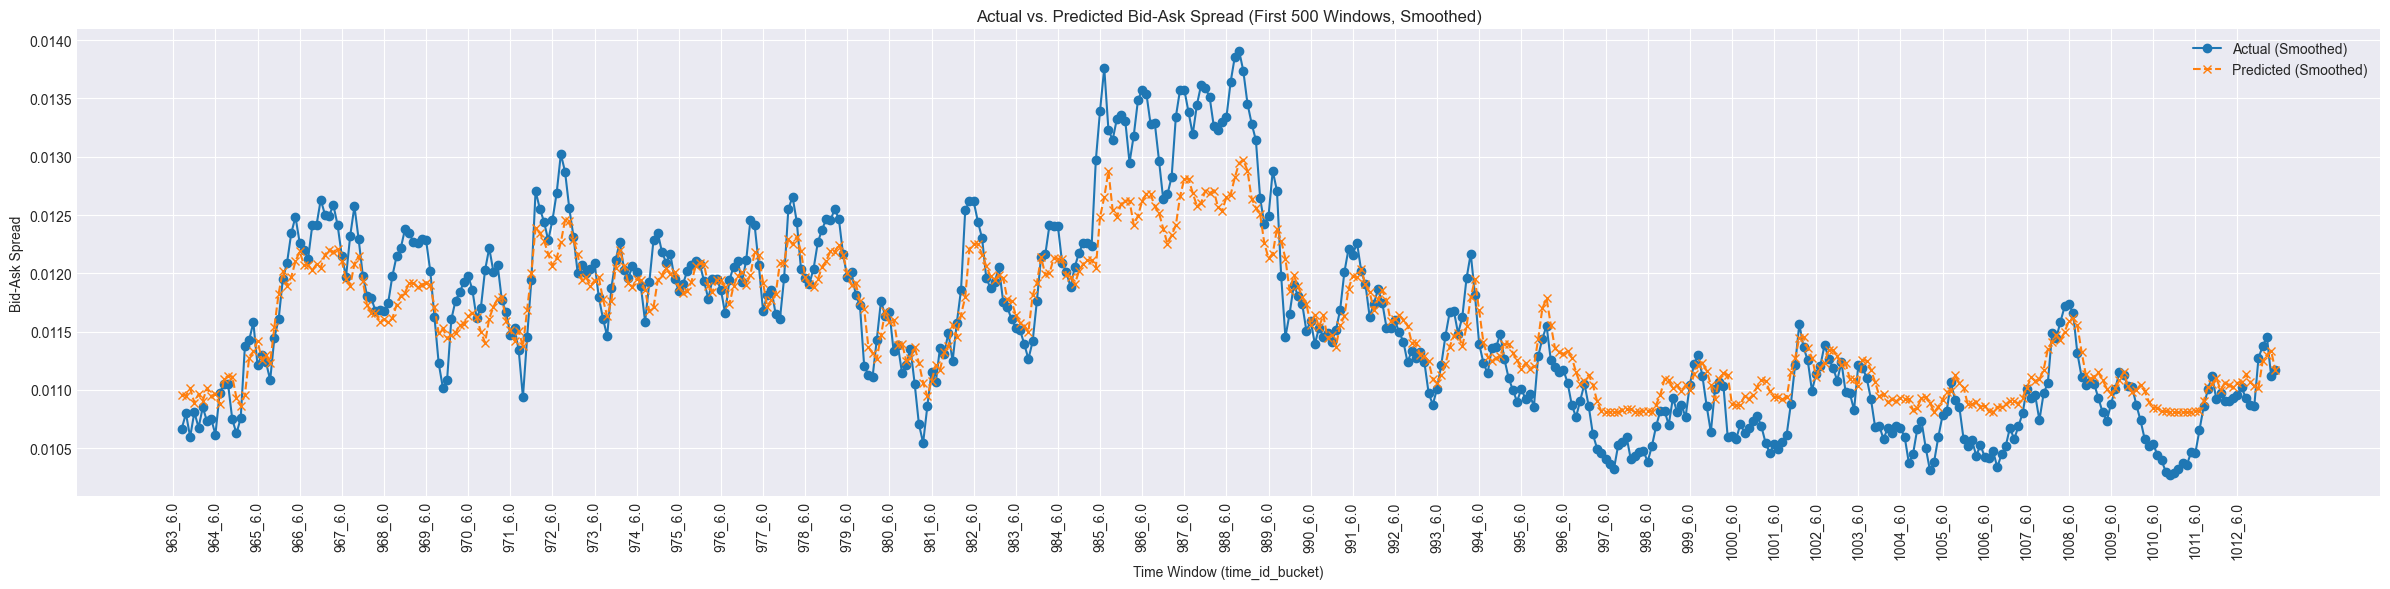

In [46]:
import matplotlib.pyplot as plt

# Slice first 500 rows
subset = comparison_df_best.head(500).copy()

# Optional: create composite label if not already present
if 'window_label' not in subset.columns:
    subset['window_label'] = subset['time_id'].astype(str) + '_' + subset['bucket_id_330s'].astype(str)

# Optional smoothing
subset['actual_smoothed'] = subset['actual_bid_ask_spread'].rolling(window=3).mean()
subset['predicted_smoothed'] = subset['predicted_bid_ask_spread'].rolling(window=3).mean()

# Plot
plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_smoothed'], label='Actual (Smoothed)', marker='o')
plt.plot(subset['window_label'], subset['predicted_smoothed'], label='Predicted (Smoothed)', marker='x', linestyle='--')

plt.title("Actual vs. Predicted Bid-Ask Spread (First 500 Windows, Smoothed)")
plt.xlabel("Time Window (time_id_bucket)")
plt.ylabel("Bid-Ask Spread")
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Simple Mid-price prediction model

In [47]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation', 'bid_ask_spread', 'mid_price',

    ]
    return df[keep_cols]

In [48]:
feature_engineered_df = compute_orderbook_features(combined_df)

feature_engineered_df["log_return"] = feature_engineered_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))

# Compute realized volatility per time_id
rv_df = feature_engineered_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into qqq_df
feature_engineered_df = pd.merge(feature_engineered_df, rv_df, on="time_id", how="left")
feature_engineered_df = feature_engineered_df[feature_engineered_df["stock_id"] == 50200].copy()
feature_engineered_df['bucket_id_330s'] = feature_engineered_df['seconds_in_bucket'] // 330
feature_engineered_df = feature_engineered_df.groupby(['time_id', 'bucket_id_330s']).agg({
    "realized_volatility": "mean",
    "wap": "mean",
    "mid_price": "mean", 
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()

feature_engineered_df = feature_engineered_df.drop(columns=[ 'time_id', 'bucket_id_330s'])
feature_engineered_df['mid_price_lead1'] = feature_engineered_df['mid_price'].shift(-1)
feature_engineered_df = feature_engineered_df.dropna(subset=['mid_price_lead1'])

MSE: 0.154933
MAE: 0.189377
RMSE: 0.393615
R²: 0.9997


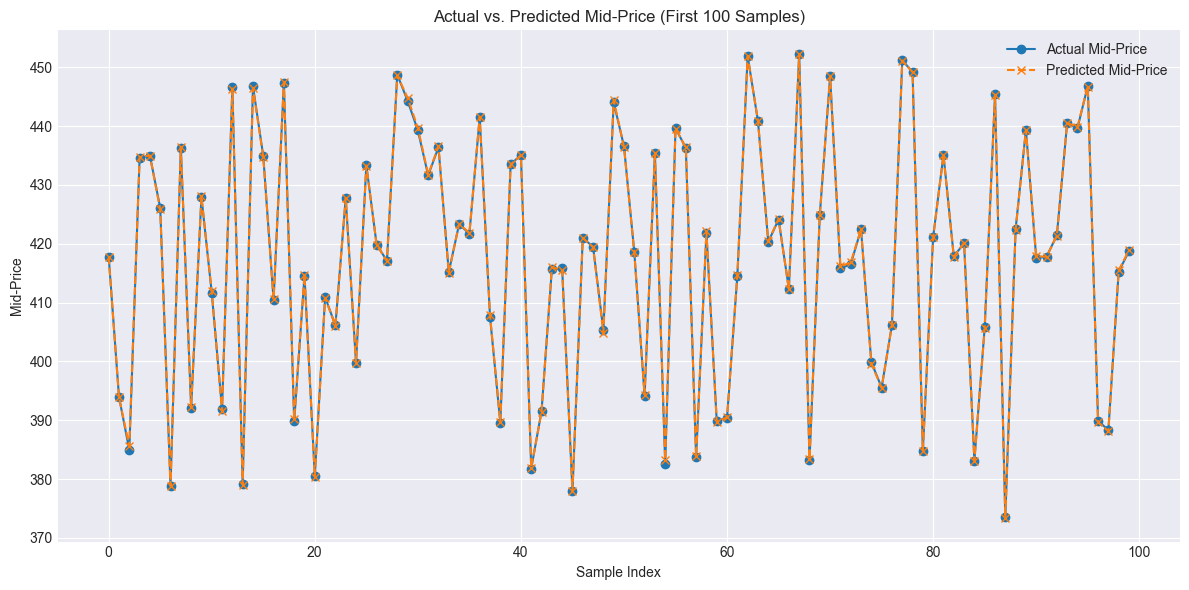

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Drop NA rows (if any)
model_df = feature_engineered_df.dropna(subset=['mid_price', 'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation', 'bid_ask_spread', 'realized_volatility'])

# Define features and target
features = [
    'spread_pct', 'imbalance', 'depth_ratio',
    'spread_variation', 'bid_ask_spread', 'mid_price',
    'realized_volatility'
]
X = model_df[features]
y = model_df['mid_price_lead1']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict mid-price on test set
y_pred = model.predict(X_test)

joblib.dump(model, "mid_price_model.pkl")

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual Mid-Price', marker='o')
plt.plot(y_pred[:100], label='Predicted Mid-Price', marker='x', linestyle='--')
plt.title("Actual vs. Predicted Mid-Price (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Mid-Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\dungh\AppData\Local\Temp\ipykernel_24208\2821895183.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")


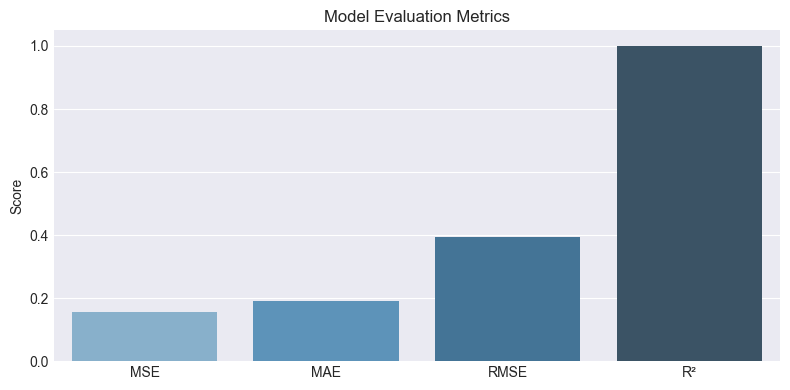

In [50]:
metrics = {
    'MSE': mse,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2
}

plt.figure(figsize=(8, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Quoting Price

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Features for each model
mid_price_features = [
    'spread_pct', 'imbalance', 'depth_ratio',
    'spread_variation', 'bid_ask_spread', 'mid_price',
    'realized_volatility'
]

spread_features = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled', 'wap', 'imbalance', 'depth_ratio', 'spread_variation', 'log_return', 'bid_ask_spread']

# --- Load models ---
mid_model = joblib.load("mid_price_model.pkl")
spread_model = joblib.load("bid_ask_spread_model.pkl")

# --- Select one random row from your full feature set ---
random_row = feature_engineered_df.sample(1, random_state=42).copy()
next_index = random_row.index[0] + 1

# --- Simulate predicted_volatility_lead1 ---
random_row['predicted_volatility_lead1'] = random_row['realized_volatility']  # or insert actual prediction

# --- Standardize relevant features for spread model ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(random_row[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
random_row[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = scaled_values

# --- Extract inputs ---
X_mid = random_row[mid_price_features]
X_spread = random_row[spread_features]

# --- Predict mid price and spread ---
pred_mid_price = mid_model.predict(X_mid)[0]
pred_spread = spread_model.predict(X_spread)[0]

# --- Compute quote ---
bid = pred_mid_price - pred_spread / 2
ask = pred_mid_price + pred_spread / 2

# --- Output ---
print("Quoting Price in next 330s Window:")
print(f"Predicted Mid Price (t+1): {pred_mid_price:.6f}")
print(f"Predicted Spread (t+1):    {pred_spread:.6f}")
print(f"→ Quoted Bid:               {bid:.6f}")
print(f"→ Quoted Ask:               {ask:.6f}")

if next_index in feature_engineered_df.index:
    actual_mid = feature_engineered_df.loc[next_index, 'mid_price']
    actual_spread = feature_engineered_df.loc[next_index, 'bid_ask_spread']
    real_bid = actual_mid - actual_spread / 2
    real_ask = actual_mid + actual_spread / 2

    print("\nReal Prices:")
    print(f"Actual Mid Price (t+1): {actual_mid:.6f}")
    print(f"Actual Spread (t+1):    {actual_spread:.6f}")
    print(f"→ Real Bid:              {real_bid:.6f}")
    print(f"→ Real Ask:              {real_ask:.6f}")

Quoting Price in next 330s Window:
Predicted Mid Price (t+1): 417.802127
Predicted Spread (t+1):    0.011551
→ Quoted Bid:               417.796352
→ Quoted Ask:               417.807903

Real Prices:
Actual Mid Price (t+1): 417.816652
Actual Spread (t+1):    0.011424
→ Real Bid:              417.810939
→ Real Ask:              417.822364
